In [19]:
import pandas as pd

DATASETS_PATH = 'data/datasets'

df = pd.read_csv(f'{DATASETS_PATH}/A1R.csv', header=0, na_values=('NA', 'nan', 'NaN'))
df

,SMILES,Target,regression_label,classification_label,Target_Seq
0,C#CCCCCCCCCCNC(=O)Oc1cccc(-n2ccc(C(N)=O)c2)c1,P30542,5.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
1,C#CCO[C@H]1CN2CCC1CC2.O=C(O)/C=C/C(=O)O,P30542,4.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
2,C#CCn1c(-c2ccco2)nc2c(N)nc(C#CC3(O)CCCCC3)nc21,P30542,9.396856,-1,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
3,C#CCn1c(-c2ccco2)nc2c(N)nc(C#CCCCCCC)nc21,P30542,8.443577,-1,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
4,C#CCn1c(Br)nc2c(N)nc(C#CC3(O)CCCCC3)nc21,P30542,9.300162,-1,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
...,...,...,...,...,...
585,c1cncc(Nc2ncc(-c3ccncn3)c(-c3ccco3)n2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
586,c1cncc(Nc2ncc(-c3ccncn3)c(-c3cccs3)n2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
587,c1cncc(Nc2ncc(-c3ccnnc3)c(-c3ccco3)n2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
588,c1coc(-c2nc(Nc3cncnc3)ncc2-c2ccncn2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...


In [5]:
import os
from qsprpred.data.data import QSPRDataset
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import DescriptorsCalculator
from qsprpred.data.utils.datasplitters import scaffoldsplit

DATA_PATH_QSAR = "data/datasets/qsar"
os.makedirs(DATA_PATH_QSAR, exist_ok=True)

# create the data set
dataset = QSPRDataset(
    name="A1R",
    df=df, 
    target_prop="regression_label", 
    store_dir=DATA_PATH_QSAR,
)
dataset.makeClassification(th=[6.5])

# Calculate MorganFP and physicochemical properties
feature_calculator = DescriptorsCalculator(descsets = [
    FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)
])

# split on scaffolds
split = scaffoldsplit(test_fraction=0.2)

dataset.prepareDataset(
    split=split,
    feature_calculator=feature_calculator
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}, {len(dataset.y_ind) / len(dataset.df) * 100}%")

Missing values filled with nan
e:\python_workplace\DrugEx\venv\lib\site-packages\qsprpred\data\data.py:493: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f"Scaffold_{scaffold}"] = self.apply(


Number of samples train set: 470
Number of samples test set: 120, 20.33898305084746%


In [6]:
from qsprpred.models.models import QSPRsklearn
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators' : [50, 250],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    "n_jobs": [1]
}

model = QSPRsklearn(
    name="A1R_RandomForestClassifier",
    base_dir='data/models/qsar/',
    data=dataset, 
    alg = RandomForestClassifier()
)

model.gridSearch(search_space_gs=params)
model.evaluate()
model.fit()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


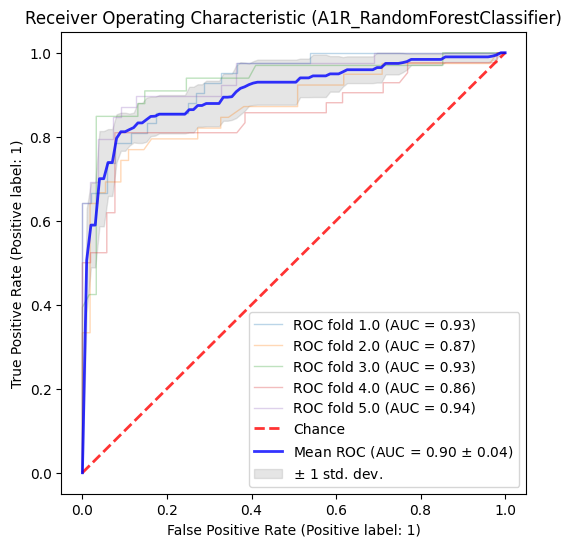

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [7]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make('cv', save = True, show=True)

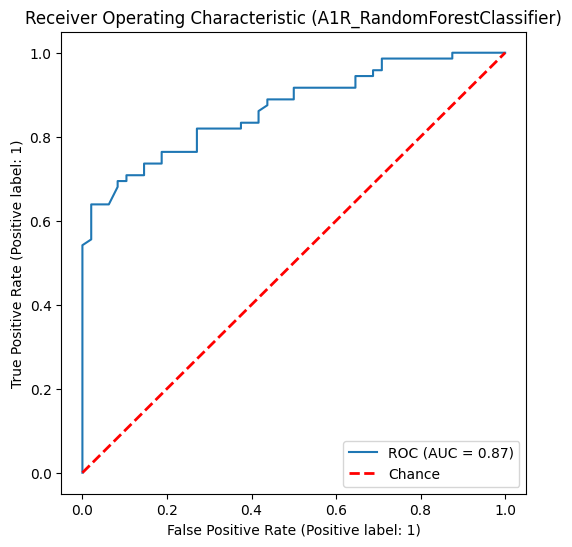

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [8]:
plot = ROCPlot([model])
plot.make('ind', save = True, show=True)

In [29]:
sample_inputs = [
    'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',  # caffeine
    # SCH-58261 (50x more selective to A2A than caffeine -> more potent),
    'c1ccccc1CCN1N=CC2=C1N=C(N)N3C2=NC(C4=CC=CO4)=N3',
    # N6-Cyclopentyladenosine
    'C1CCC(C1)NC2=C3C(=NC=N2)N(C=N3)C4C(C(C(O4)CO)O)O',
    'OC[C@H]1O[C@@H](n2cnc3c(NC4CCCC4)ncnc32)[C@H](O)[C@@H]1O',
    'C1CCC(C1)NC2=C3C(=NC=N2)N(C=N3)[C@H]4[C@@H]([C@@H]([C@H](O4)CO)O)O',
]


In [30]:
model.predictMols(sample_inputs, use_probas=True)

Missing values filled with nan
e:\python_workplace\DrugEx\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.976, 0.024],
       [0.896, 0.104],
       [0.024, 0.976],
       [0.024, 0.976],
       [0.024, 0.976]])

In [1]:
from rdkit import Chem
supply = Chem.SDMolSupplier('data.sdf')  # name the path of the SDF file
mols = [x for x in supply]
len(mols)

with Chem.MultithreadedSDMolSupplier('data.sdf') as sdSupl:
    mols = [x for x in sdSupl if x is not None]
len(mols)


30009

In [14]:
Chem.Mol

AttributeError: 'Mol' object has no attribute 'name'

In [11]:
nmol = 

In [18]:
nsmile = Chem.MolToSmiles(Chem.MolFromSmiles('CC(=O)Nc1ccc(-c2nc(SCc3csc(-c4ccc(Cl)cc4)n3)nc(N)c2C#N)cc1'))
nsmile

'CC(=O)Nc1ccc(-c2nc(SCc3csc(-c4ccc(Cl)cc4)n3)nc(N)c2C#N)cc1'

In [4]:
smiles = [Chem.MolToSmiles(x) for x in mols]

In [5]:
smiles[0]

'CC(C)(C)NCC(=O)Nc1c2c(nc3c1CCC3)CCCC2'

In [20]:
from qsprpred.models.models import QSPRsklearn

predictor = QSPRsklearn(
    name='A1R_RandomForestClassifier',
    base_dir='./data/models/qsar'
)

# pred = predictor.predictMols(smiles, use_probas=True)


In [29]:
x = predictor.predictMols(df['SMILES'], use_probas=True)


Missing values filled with nan
e:\python_workplace\DrugEx\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [31]:
x[0]

array([0.948, 0.052])

In [21]:
from drugex.training.scorers.qsprpred import QSPRPredScorer

qsprpred_scorer = QSPRPredScorer(
    predictor
)

# qsprpred_scorer.getScores(df['SMILES'])
pred = qsprpred_scorer.model.predictMols(df['SMILES'], use_probas=True)


Missing values filled with nan
e:\python_workplace\DrugEx\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [10]:
with open('cortelis.csv', 'w') as f:
    f.write('SMILES,Prediction\n')
    for smile, p in zip(df['SMILES'], pred):
        f.write('{},{}\n'.format(smile, p[1]))

In [6]:
pred = qsprpred_scorer.getScores(df['SMILES'])

Missing values filled with nan
e:\python_workplace\DrugEx\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [7]:
pred.shape

(590,)

In [8]:
import numpy as np
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [10]:
labels = 1/(1 + np.exp(-df['regression_label']))

In [11]:
BinaryCrossEntropy(pred, labels)

2.9943507877244144

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GNNStack, self).__init__()
        nn1 = nn.Sequential(nn.Linear(num_edge_features, 128), nn.ReLU(), nn.Linear(128, hidden_dim * input_dim))
        self.conv1 = NNConv(input_dim, hidden_dim, nn1)
        nn2 = nn.Sequential(nn.Linear(num_edge_features, 128), nn.ReLU(), nn.Linear(128, hidden_dim * hidden_dim))
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn2)

        # post message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.5), nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, data):
        x = data.x.float()
        edge_attr = data.edge_attr.float()
        edge_index = data.edge_index
        
        # 1. Obtain node embeddings
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))

        # readout
        x = pyg_nn.global_mean_pool(x, data.batch)

        # post message-passing
        x = self.post_mp(x)
        x = torch.sigmoid(x)
        # x = F.normalize(x, p=2., dim=-1)
        return x

In [17]:
model = GNNStack(133, 128, 1)

NameError: name 'num_edge_features' is not defined